In [6]:
%matplotlib inline
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt

!wget -nc http://images.cocodataset.org/zips/val2017.zip
!unzip -q -n val2017.zip -d /content/
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q -n annotations_trainval2017.zip -d /content/

img_folder = "/content/val2017"
ann_file = "/content/annotations/instances_val2017.json"

class COCOSegmentationDataset(Dataset):
    def __init__(self, img_folder, ann_file, transforms=None):
        self.coco = COCO(ann_file)
        self.img_ids = list(self.coco.imgs.keys())
        self.img_folder = img_folder
        self.transforms = transforms

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_folder, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        masks = []
        boxes = []
        labels = []
        for ann in anns:
            if "segmentation" in ann:
                mask = self.coco.annToMask(ann)
                masks.append(mask)
                x, y, w, h = ann["bbox"]
                boxes.append([x, y, x + w, y + h])
                labels.append(ann["category_id"])

        if masks:
            masks = np.stack(masks, axis=0)
        else:
            masks = np.zeros((0, img_info["height"], img_info["width"]))

        if self.transforms:
            image = self.transforms(image)

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "masks": torch.as_tensor(masks, dtype=torch.uint8),
            "image_id": torch.tensor([img_id]),
        }

        return image, target

transform = T.Compose([T.ToTensor()])
full_dataset = COCOSegmentationDataset(img_folder, ann_file, transforms=transform)
subset_indices = list(range(20))
dataset = Subset(full_dataset, subset_indices)

data_loader = DataLoader(dataset, batch_size=2, shuffle=True,
                         collate_fn=lambda x: tuple(zip(*x)))




File ‘val2017.zip’ already there; not retrieving.

File ‘annotations_trainval2017.zip’ already there; not retrieving.

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = maskrcnn_resnet50_fpn(weights="DEFAULT")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")




Epoch 1/2, Loss: 13.4736
Epoch 2/2, Loss: 12.8366


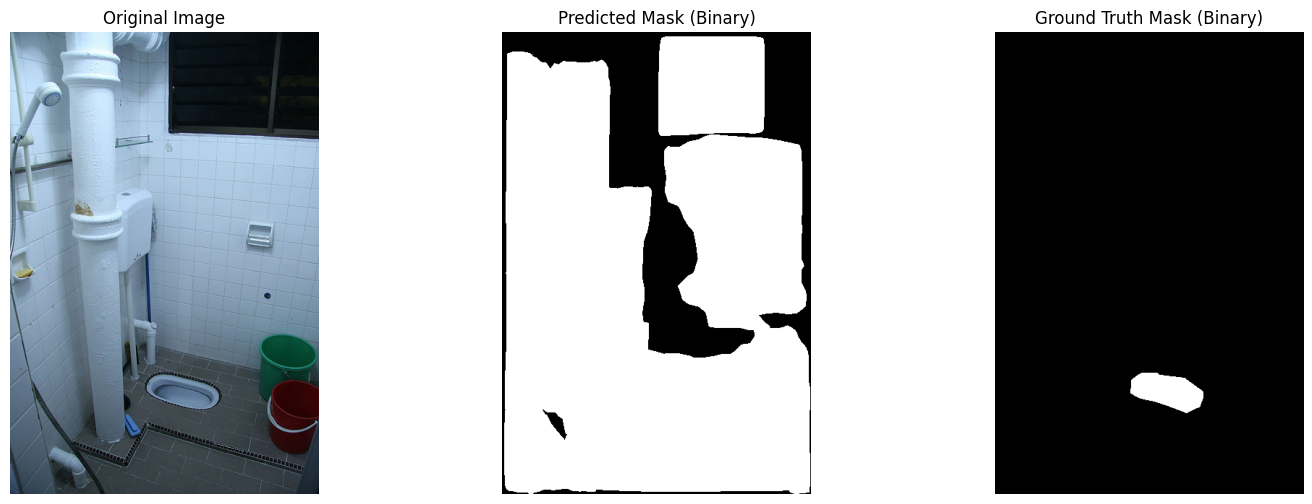

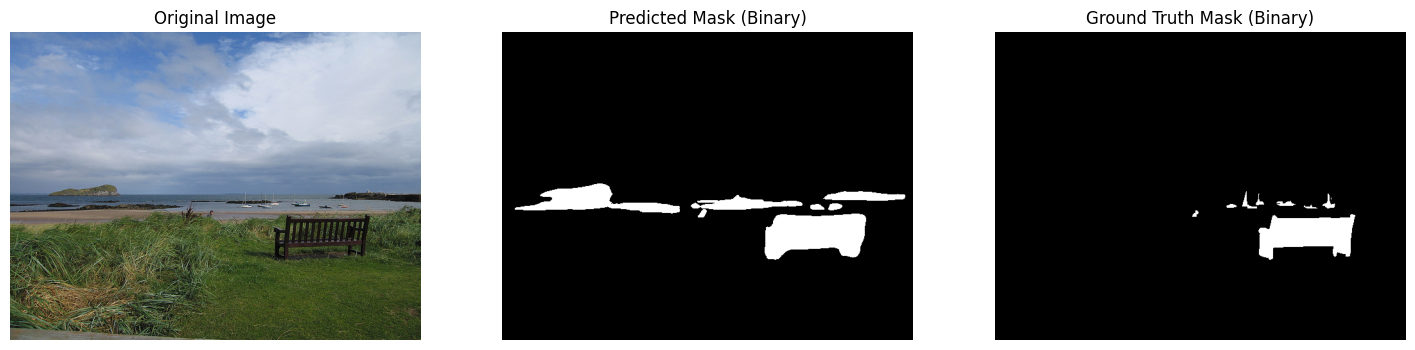

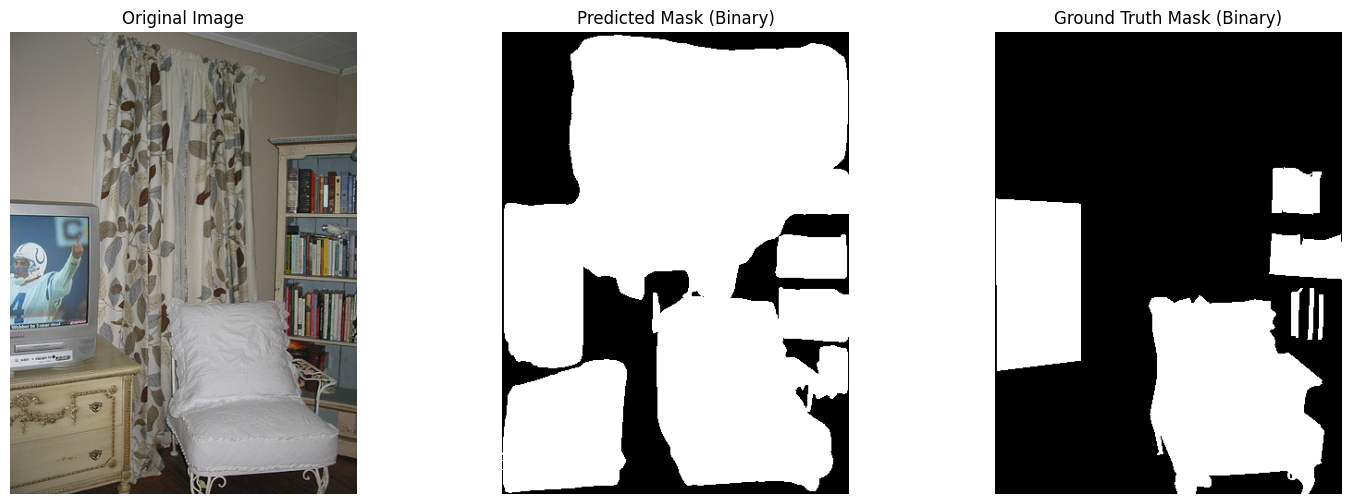

In [8]:
def visualize_binary_masks(model, dataset, device, num_images=3, score_threshold=0.7):
    model.eval()
    for _ in range(num_images):
        idx = torch.randint(0, len(dataset), (1,)).item()
        image, target = dataset[idx]
        H, W = image.shape[1], image.shape[2]

        image_small = T.functional.resize(image, (256, 256))
        with torch.no_grad():
            prediction = model([image_small.to(device)])

        pred_masks = []
        for mask in prediction[0]['masks'].cpu():
            mask_resized = T.functional.resize(mask[0][None, :, :], (H, W))
            pred_masks.append((mask_resized[0].numpy() > 0.5).astype(np.uint8))

        gt_masks = [(m.numpy().astype(bool)).astype(np.uint8) for m in target['masks']]

        pred_combined = np.zeros((H, W), dtype=np.uint8)
        for m in pred_masks:
            pred_combined = np.maximum(pred_combined, m)

        gt_combined = np.zeros((H, W), dtype=np.uint8)
        for m in gt_masks:
            gt_combined = np.maximum(gt_combined, m)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(image.permute(1, 2, 0).numpy())
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(pred_combined, cmap='gray')
        axes[1].set_title("Predicted Mask (Binary)")
        axes[1].axis('off')

        axes[2].imshow(gt_combined, cmap='gray')
        axes[2].set_title("Ground Truth Mask (Binary)")
        axes[2].axis('off')

        plt.show()

visualize_binary_masks(model, dataset, device, num_images=3)

In [9]:
import torch
import numpy as np
from torchvision import transforms as T

def evaluate_binary_masks(model, dataset, device, score_threshold=0.5):
    model.eval()
    pixel_accuracies = []
    iou_scores = []

    for idx in range(len(dataset)):
        image, target = dataset[idx]

        image_small = T.functional.resize(image, (256, 256))
        gt_masks = target['masks'].numpy()
        if gt_masks.shape[0] > 0:
            gt_binary = np.any(gt_masks, axis=0).astype(np.uint8)
            gt_binary_resized = T.functional.resize(torch.tensor(gt_binary).unsqueeze(0).unsqueeze(0).float(),
                                                     (256, 256)).squeeze().numpy()
        else:
            gt_binary_resized = np.zeros((256, 256), dtype=np.uint8)

        with torch.no_grad():
            prediction = model([image_small.to(device)])

        pred_masks = prediction[0]['masks'].cpu().numpy()
        pred_scores = prediction[0]['scores'].cpu().numpy()

        if len(pred_masks) > 0:
            keep = pred_scores >= score_threshold
            if keep.any():
                pred_binary = np.any(pred_masks[keep, 0], axis=0).astype(np.uint8)
            else:
                pred_binary = np.zeros((256, 256), dtype=np.uint8)
        else:
            pred_binary = np.zeros((256, 256), dtype=np.uint8)

        pixel_acc = np.mean(pred_binary == gt_binary_resized)
        pixel_accuracies.append(pixel_acc)

        intersection = np.logical_and(pred_binary, gt_binary_resized).sum()
        union = np.logical_or(pred_binary, gt_binary_resized).sum()
        iou = intersection / union if union > 0 else 1.0
        iou_scores.append(iou)

    avg_pixel_acc = np.mean(pixel_accuracies)
    avg_iou = np.mean(iou_scores)

    print(f"Average Pixel Accuracy: {avg_pixel_acc:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")

evaluate_binary_masks(model, dataset, device, score_threshold=0.5)


Average Pixel Accuracy: 0.7465
Average IoU: 0.4791
